# Cropping Object frames
* The code written is based on methods from [LeagueAI](https://arxiv.org/abs/1905.13546) and the associated [Github repo](https://github.com/Oleffa/LeagueAI)
## Methodology
1. Removing the unicolor background of the images by modifying the alpha channel(for transparency) of all unicolor pixels.
2. Image is cropped.
3. Cropped dimensions will serve as bounding boxes.

In [11]:
import os
from PIL import Image, ImageFilter
import numpy as np
from os import listdir
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm

In [12]:
def get_files_in_dir_as_dict(path, filt='.csv'):
    ''' Get all files from path. Returns a dict of folder + path'''
    assert os.path.exists(path), "The path {} was not found!".format(path)
    f = dict()
    for (dirpath, dirnames, filenames) in os.walk(path):
        files = [os.path.join(dirpath,f) for f in filenames if filt in f]
        if len(files) > 0:
            f[dirpath] = files
    return f
def get_files_in_dir_as_list(path, filt='.csv'):
    f_dict = get_files_in_dir_as_dict(path, filt)
    return [k for key in f_dict for k in f_dict[key]]

def get_precrop_area(img_size, crop_coeffs = np.array([0.13175231, 0.01315789, 0.84321476, 0.92105263])):
    ''' Pre-crop image to some unwanted elements on the screenshot'''
    # TEMPLATE_H = 380
    # TEMPLATE_W = 759
    # h0_coeff = 5/TEMPLATE_H
    # h1_coeff = 350/TEMPLATE_H
    # w0_coef = 100/TEMPLATE_W
    # w1_coeff = 640/TEMPLATE_W
    
    # crop_coeffs = np.array([0.13175231, 0.01315789, 0.84321476, 0.92105263])
    return np.multiply((*img_size, *img_size), crop_coeffs) # (*img_size, *img_size) makes a 1x4 array of w,h,w,h

In [13]:
# Area to pre-crop the images to (min_x, min_y, max_x, max_y), can save runtime for large screenshots with small objects
area = (700,300,1240,780)

tolerance_offset_1 = 1.0
tolerance_offset_2 = 1.0 # Greenscreen: 0.74
tolerance_offset_3 = 2.5 # Teemo viewer: 2.5
tolerance1 = tolerance_offset_1*25
tolerance2 = tolerance_offset_2*25
tolerance3 = tolerance_offset_3*25
tolerance = (tolerance1,tolerance2,tolerance3)
background = (0,255,0)

In [14]:
def rgba_channel_equal(c1, c2, tolerance):
    return ((abs(int(c1[0]) - int(c2[0])) <= tolerance[0]) and 
            (abs(int(c1[1]) - int(c2[1])) <= tolerance[1]) and 
            (abs(int(c1[2]) - int(c2[2])) <= tolerance[2]))

def modify_outline(image, thickness):
    #image = Image.open(f)
    #image = image.convert("RGBA")
    
    for t in range(thickness):
        mask = image.filter(ImageFilter.FIND_EDGES)
        mask_data = mask.getdata()
        image_data = image.getdata()
        w, h = mask_data.size
        
        out_data=[]
        for y in range(0, h):
            for x in range(0, w):
                index = x + w*y
                pixel = (0,0,0,0)
                if mask_data[index][3]>0:
                    pixel = (255,255,255, 0)
                else:
                    pixel = (image_data[index][0], image_data[index][1],  image_data[index][2],  image_data[index][3])
                out_data.append(pixel)
        image.putdata(out_data)
    #image.save(out)
    return image

def get_y_min_max(new_data, w, h, scan_step=5, channel=1, channel_mask=(0,255,0), tolerance=(10,10,10)):
    '''Get min max values for y axis. Axis = x'''
    min_value = 0
    max_value = 0
    for y in range(h-1, 0,-scan_step):
        for x in range(0, w-1):
            data_index = x + w * y
            #if abs(new_data[data_index][1] - 255) > 40:
            if not rgba_channel_equal(new_data[data_index], channel_mask, tolerance):
                #print('max = {}'.format(new_data[data_index][1]))
                max_value = y
                break
        else:
            continue
        break
        
    for y in range(0, h-1, scan_step):
        for x in range(0, w-1):
            data_index = x + w * y
            #if abs(new_data[data_index][1] - 255) > 40: 
            if not rgba_channel_equal(new_data[data_index], channel_mask, tolerance):
                min_value = y
                #print('min = {}'.format(new_data[data_index][1]))
                break
        else:
            continue
        break
    return min_value-scan_step, max_value+scan_step

def get_xy_min_max(tgt_img, scan_step=1, channel=1, channel_mask=(0,255,0), tolerance=(10,10,10)):
    # y axis
    img_data = tgt_img.getdata()
    w,h = tgt_img.size
    min_y, max_y = get_y_min_max(img_data,w=w,h=h, 
                                 channel=channel, 
                                 channel_mask=channel_mask, 
                                 tolerance=tolerance,
                                scan_step=scan_step)
    
    # X axis
    img = tgt_img.rotate(-90,expand=True)
    img_data = img.getdata()
    w,h = img.size
    min_x,max_x = get_y_min_max(img_data,w=w,h=h, 
                                 channel=channel, 
                                 channel_mask=channel_mask, 
                                 tolerance=tolerance,
                                scan_step=scan_step)
    
    return min_x, min_y, max_x, max_y-scan_step//2

In [15]:
def img_2_cropped_png(input_img_path, background=(0,255,0), tolerance=(10,40,10), 
                      precrop_bbox= np.array([0.13175231, 0.01315789, 0.84321476, 0.92105263])):
    tolerance1, tolerance2, tolerance3 = tolerance
    img = Image.open(input_img_path)

    # Add alpha channel
    img = img.convert("RGBA")
    
    # Crop initially to remove logo etc
    # img = img.crop((100,20,730,420))
    crop_bbox = get_precrop_area(img.size, precrop_bbox)
    img = img.crop(crop_bbox)
    dim = get_xy_min_max(img, channel_mask=background, tolerance=(5,40,5), scan_step=10)
    img_cropped = img.crop((dim))
    datas = img_cropped.getdata()
    newData = list(datas)
    
    for idx, item in zip(range(len(datas)), datas):
        if (abs(item[0] - background[0]) < tolerance1 and 
         abs(item[1] - background[1]) < tolerance2 and 
         abs(item[2] - background[2]) < tolerance3): 
             newData[idx] = (255,255,255,0)
        else:
            newData[idx] = (item[0], item[1], item[2], 255)
            
    img_cropped.putdata(newData)
    w,h = img_cropped.size
    # Crop image to pixel content
    dim = get_xy_min_max(img_cropped, channel_mask=background, tolerance=(5,40,5), scan_step=1)
    # Save output image as png
    img_cropped = img_cropped.crop(dim)
    img_cropped = modify_outline(img_cropped, 1)
    #img_cropped.save()
    return img_cropped

def img_2_cropped_png_wrapper(input_img_path, background=(0,255,0),out_path= 'creeps_cropped', source_dir = 'creeps',
                             precrop_bbox = np.array([0.13175231, 0.01315789, 0.84321476, 0.92105263])):
    img = img_2_cropped_png(input_img_path, background=background, tolerance=tolerance, precrop_bbox=precrop_bbox)
    if img == None:
        return False
    rel_path = os.path.relpath(input_img_path, source_dir)
    save_path = os.path.join(out_path, os.path.dirname(rel_path))
    #print(save_path)
    base_name = os.path.basename(input_img_path)
    if(not os.path.exists(save_path)):
        os.makedirs(save_path)
    #print(save_path)
    img.save(os.path.join(save_path,base_name))
    return True

# Crop Champion Images

In [16]:
root_dir = 'v2_01_champions_10/'
image_paths = get_files_in_dir_as_list(root_dir, 'png')
out_path = 'v2_01_champs_cropped' ########################TODO!!

In [17]:
len(image_paths)

4344

In [18]:
for img in tqdm(image_paths):
    img_2_cropped_png_wrapper(img,out_path=out_path,source_dir=root_dir)

100%|██████████████████████████████████████████████████████████████████████████████| 4344/4344 [09:44<00:00,  7.44it/s]


# Crop creep images

In [19]:
background = (4, 244, 4) # Green screen
out_path = 'creeps_cropped/'
creep_image_paths = get_files_in_dir_as_list('creeps', 'png')

In [43]:
for img in tqdm(creep_image_paths):
    img_2_cropped_png_wrapper(input_img_path=img, background=background, out_path=out_path,source_dir=')

100%|██████████████████████████████████████████████████████████████████████████████| 9980/9980 [25:46<00:00,  6.45it/s]


# Crop Monster Images

In [30]:
background = (4, 244, 4) # Green screen
source_dir = 'v2_1_monsters/'
monster_image_paths = get_files_in_dir_as_list(source_dir, 'png')
out_path = 'v2_1_monsters_cropped/'
len(monster_image_paths)

# Skip Gromp. Has to be processed seperately
monster_image_paths2 = [x for x in monster_image_paths if 'Gromp' not in x]
gromp_image_paths = [x for x in monster_image_paths if 'Gromp' in x]
len(monster_image_paths2)

2536

In [9]:
for img in tqdm(monster_image_paths2):
    img_2_cropped_png_wrapper(input_img_path=img, background=background, out_path=out_path,source_dir=source_dir)
    

NameError: name 'monster_image_paths2' is not defined

In [32]:
for img in tqdm(gromp_image_paths):
    img_2_cropped_png_wrapper(input_img_path=img, 
                              background=background, 
                              out_path=out_path,
                              source_dir=source_dir,
                             precrop_bbox = np.array([0.13175231, 0.01315789, 0.84321476, 0.60]))
    

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:13<00:00,  7.88it/s]


In [25]:
out_path

'v2_monsters_cropped/'

# Random Tests

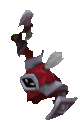

In [4]:
im_obj.paste()